# Machine Learning Project

## A2 - Car Price Prediction

The aim of the project is to train and evaluate one or more regression models in order to predict the selling price of used cars. The project is based on a dataset containing about 40.000 examples of used cars, sold in the UK.

## Imported libraries

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from IPython.display import Markdown, display

import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import keras_tuner
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

## Load the data

I loaded the dataset, provided in the CSV file car_prices.csv and I printed the first 5 examples.

In [2]:
dataset = pd.read_csv("/Users/silviaperelli/Desktop/car_prices.csv")
dataset.head()

,manufacturer,model,year,transmission,mileage,fuelType,mpg,engineSize,price
0,Audi,A1,2017,Manual,15735,Petrol,55.4,1.4,12500
1,Audi,A6,2016,Automatic,36203,Diesel,64.2,2.0,16500
2,Audi,A1,2016,Manual,29946,Petrol,55.4,1.4,11000
3,Audi,A4,2017,Automatic,25952,Diesel,67.3,2.0,16800
4,Audi,A3,2019,Manual,1998,Petrol,49.6,1.0,17300


I also divided the dataset in features and target.

In [3]:
X = dataset.drop('price', axis = 1)
y = dataset['price']

## Create a training set, validation set and a test set

I randomly split the dataset into a training set, validation set and a test set; the training set is used to train the different models, the validation set to calculate the errors on new predictions and the test set to verify again the performance of the best models on new data. The split I used is approximately: 70% training set, 10% validation set and 20% test set.

I used the function train_test_split, offered by Scikit-learn for this task, to do a first split of the data and then I did a second split of the training set to create all the three sets. I also joined the x_train and y_train to create the training set.

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# split again
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42) 

data_train = pd.concat([X_train, y_train], axis=1)

## Data analysis and cleaning

The training set contains about 30.000 non-null entries and there are four categorical attributes and five numerical attributes.

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29740 entries, 40469 to 5314
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  29740 non-null  object 
 1   model         29740 non-null  object 
 2   year          29740 non-null  int64  
 3   transmission  29740 non-null  object 
 4   mileage       29740 non-null  int64  
 5   fuelType      29740 non-null  object 
 6   mpg           29740 non-null  float64
 7   engineSize    29740 non-null  float64
 8   price         29740 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 2.3+ MB


I divided the features in two groups: numerical and categorical.

In [6]:
numerical_features = data_train.loc[:, (data_train.dtypes == int) | (data_train.dtypes == float)].columns.tolist()
categorical_features = data_train.loc[:, (data_train.dtypes != int) & (data_train.dtypes != float)].columns.tolist()

#### Handling missing values
First, I verify if there are any null values and I observed that all the features have valid entries.

In [7]:
data_train.isnull().sum()

manufacturer    0
model           0
year            0
transmission    0
mileage         0
fuelType        0
mpg             0
engineSize      0
price           0
dtype: int64

#### Removing duplicates

I also printed the number of unique values for each features and I looked for any duplicates. I found 322 duplicated values, so I deleted them.

In [8]:
unique_counts = data_train.nunique()
print(unique_counts)

manufacturer        4
model              92
year               24
transmission        4
mileage         19317
fuelType            5
mpg               166
engineSize         38
price            7409
dtype: int64


In [9]:
data_train.duplicated().sum()

322

In [10]:
data_train = data_train.drop_duplicates()
data_train.duplicated().sum()

0

#### Outlier detection and distribution plot

I looked at the training set's description.

In [11]:
data_train.describe()

,year,mileage,mpg,engineSize,price
count,29418.000000,29418.000000,29418.000000,29418.000000,29418.000000
mean,2017.095350,23839.221803,55.723271,1.962492,21703.760181
std,2.236559,22685.987215,20.722545,0.606546,11756.033001
min,1997.000000,1.000000,1.100000,0.000000,650.000000
25%,2016.000000,6308.750000,45.600000,1.500000,13888.000000
50%,2017.000000,17496.500000,55.000000,2.000000,19674.500000
75%,2019.000000,34436.250000,64.200000,2.100000,26829.500000
max,2020.000000,323000.000000,470.800000,6.600000,159999.000000


From the descriptive statistics I found some possible outliers, for example the minimum value for engineSize is 0.0. I plotted the distribution of the numerical features with the intention of looking for any outliers among the entries.

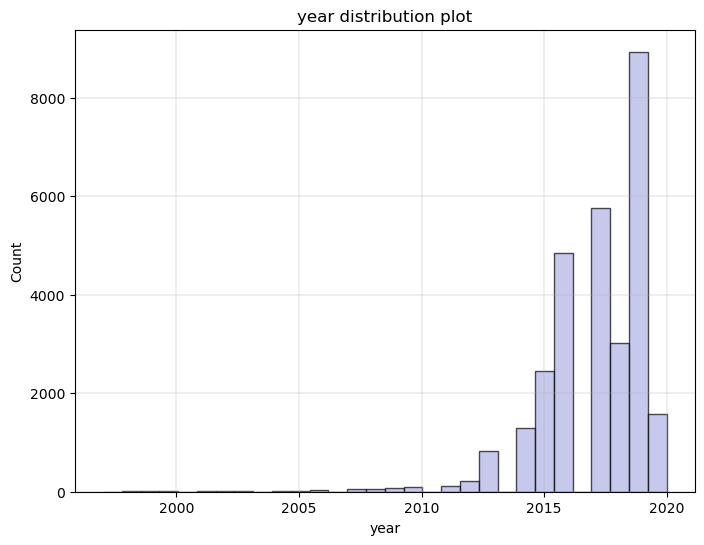

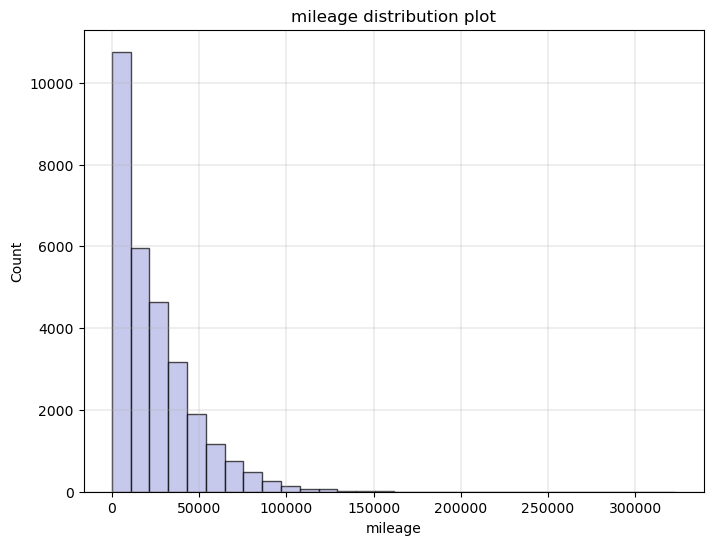

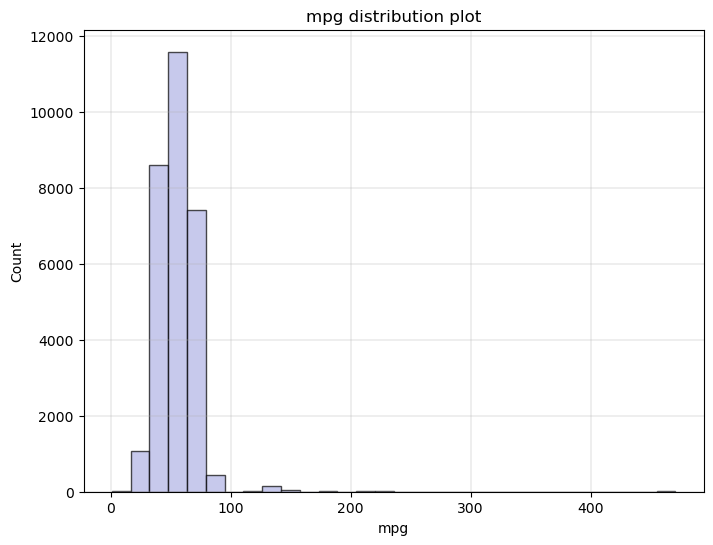

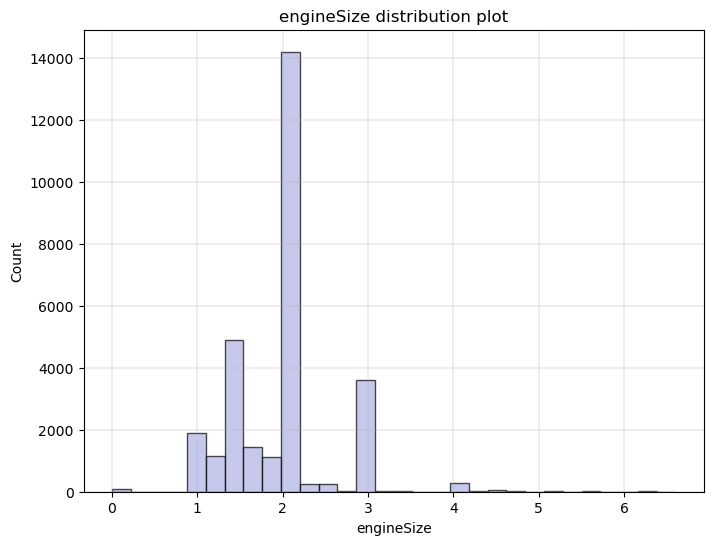

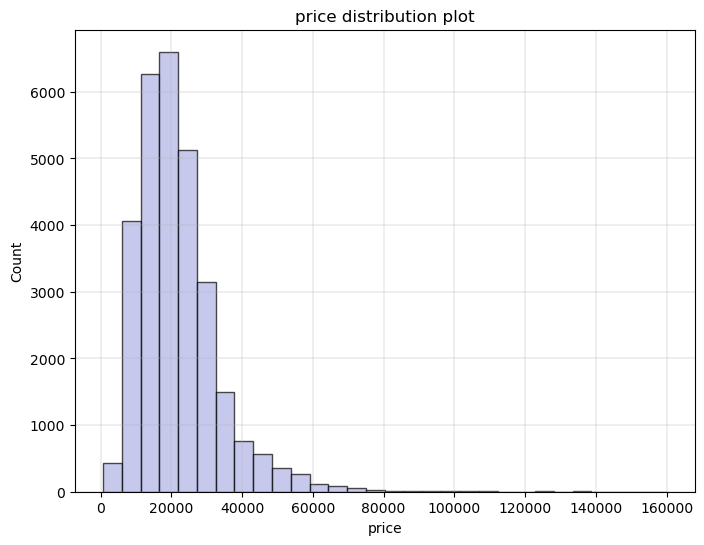

In [12]:
for feature in numerical_features:
    plt.figure(figsize = (8, 6))
    
    plt.hist(data_train[feature], bins = 30, color = "#b0b2e4", edgecolor = "black", alpha = 0.7)
    
    plt.title(f"{feature} distribution plot", fontsize = 12)
    plt.xlabel(feature, fontsize = 10)
    plt.ylabel("Count", fontsize = 10)
    plt.grid(linewidth=0.3)
    
    plt.show()

In each feature there are some outlier, some values are more rare between the entries and are very distant from the average value; so I removed them by modifying the training set with new conditions for every attribute.

In [13]:
data_train = data_train[(data_train["year"] >= 2000) & (data_train["year"] <= 2020)]
data_train = data_train[(data_train["mileage"] >= 0) & (data_train["mileage"] <= 150000)]
data_train = data_train[(data_train["mpg"] >= 0) & (data_train["mpg"] <= 250)]
data_train = data_train[(data_train["engineSize"] >= 1) & (data_train["engineSize"] <= 6)]
data_train = data_train[(data_train["price"] >= 0) & (data_train["price"] <= 80000)]

In [14]:
data_train.describe()

,year,mileage,mpg,engineSize,price
count,29211.000000,29211.000000,29211.000000,29211.000000,29211.000000
mean,2017.106296,23754.013385,55.391801,1.960060,21508.869672
std,2.186080,22261.147892,15.665711,0.578887,10948.882512
min,2000.000000,1.000000,1.100000,1.000000,650.000000
25%,2016.000000,6351.000000,45.600000,1.500000,13850.000000
50%,2017.000000,17501.000000,55.400000,2.000000,19600.000000
75%,2019.000000,34404.000000,64.200000,2.100000,26750.000000
max,2020.000000,148371.000000,235.000000,5.500000,79999.000000


I then analized the categorical features and I plotted the distribution with bar charts.

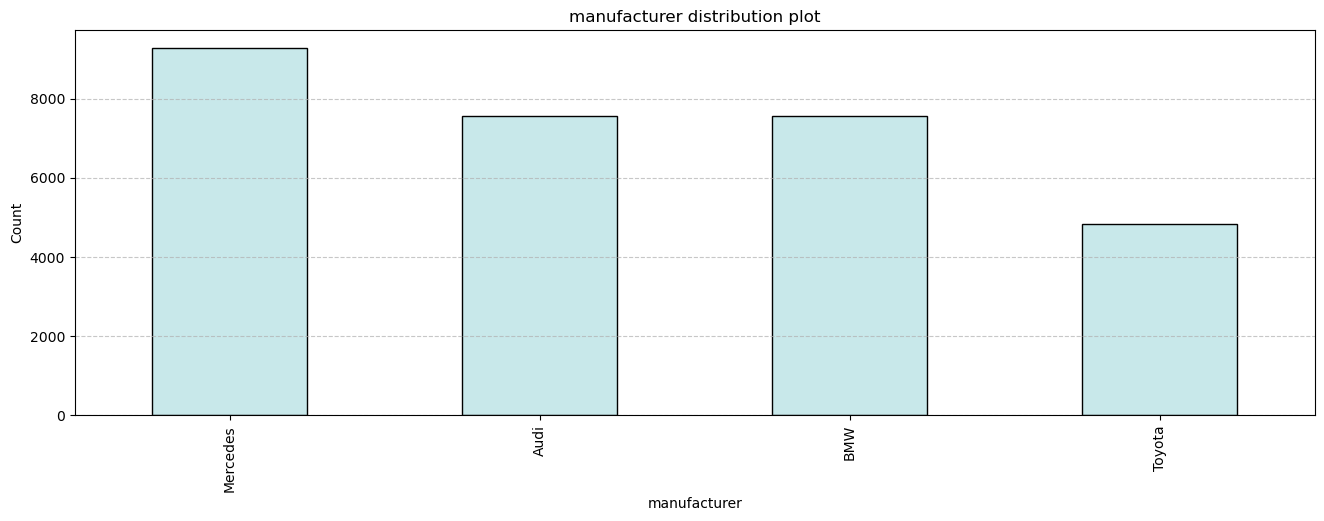

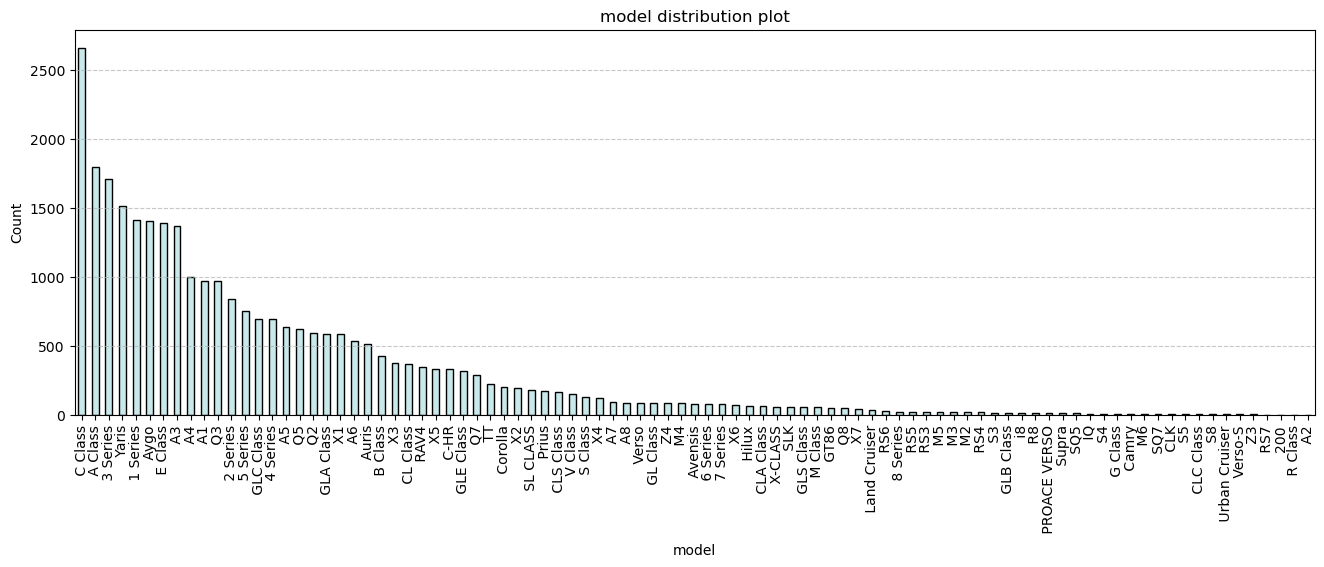

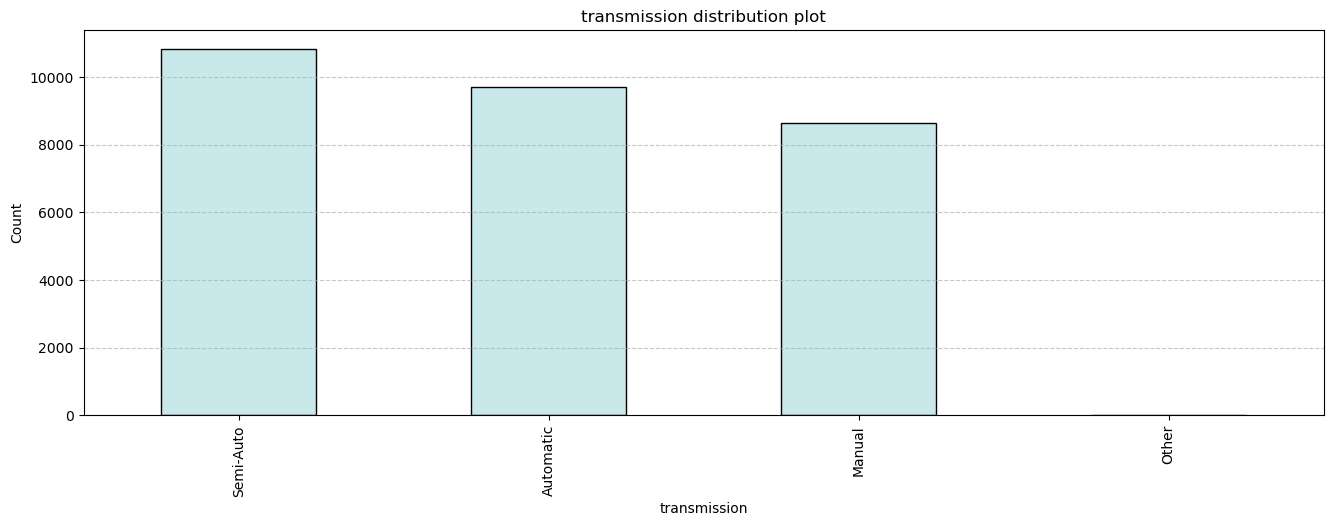

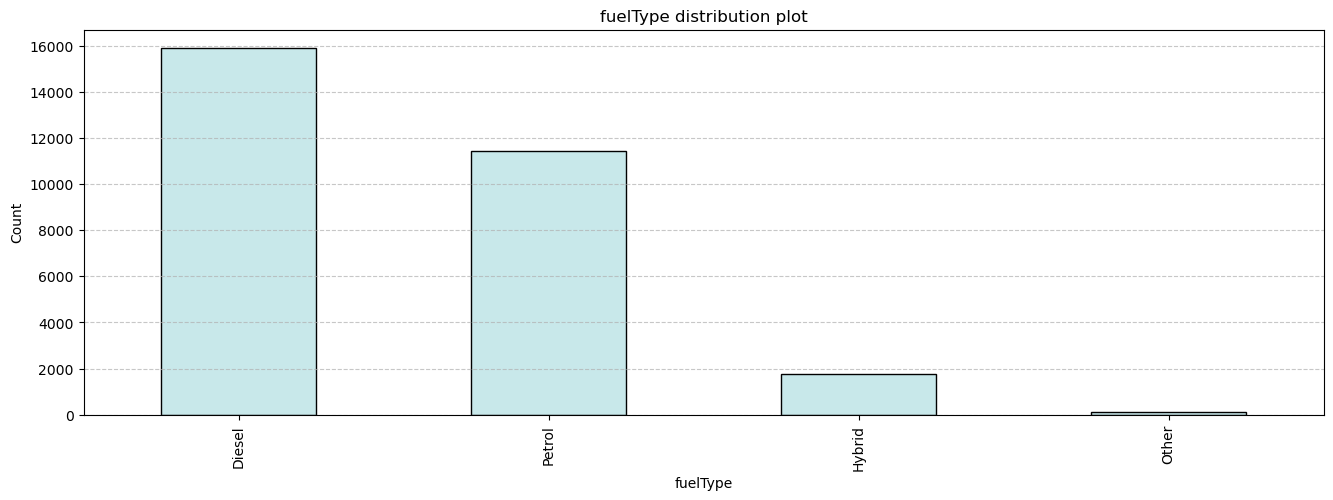

In [15]:
for feature in categorical_features:

    data_train[feature].value_counts().plot(kind='bar', figsize=(16, 5), color='#c8e8ea', edgecolor = "black")
    
    plt.title(f"{feature} distribution plot", fontsize = 12)
    plt.xlabel(feature, fontsize = 10)
    plt.ylabel("Count", fontsize = 10)
    plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
    
    plt.show() 

### Looking for correlation

I calculated the correlation between the numerical features, in particular I wanted to look at the correlation with the target. I visualized the results with a correlation matrix, created with a heatmap. I also observed the correlation between the features with a matrix composed by the scatter plot of each couple of attributes.

In [16]:
corr_matrix = data_train.corr(numeric_only=True)

In [17]:
corr_matrix["price"].sort_values(ascending=False)

price         1.000000
engineSize    0.598622
year          0.569814
mpg          -0.436502
mileage      -0.512940
Name: price, dtype: float64

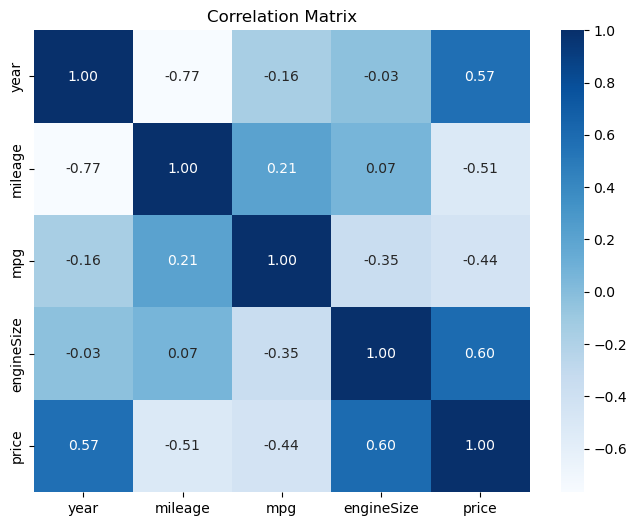

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='Blues')
plt.title("Correlation Matrix")
plt.show()

array([[<Axes: xlabel='year', ylabel='year'>,
        <Axes: xlabel='mileage', ylabel='year'>,
        <Axes: xlabel='mpg', ylabel='year'>,
        <Axes: xlabel='engineSize', ylabel='year'>,
        <Axes: xlabel='price', ylabel='year'>],
       [<Axes: xlabel='year', ylabel='mileage'>,
        <Axes: xlabel='mileage', ylabel='mileage'>,
        <Axes: xlabel='mpg', ylabel='mileage'>,
        <Axes: xlabel='engineSize', ylabel='mileage'>,
        <Axes: xlabel='price', ylabel='mileage'>],
       [<Axes: xlabel='year', ylabel='mpg'>,
        <Axes: xlabel='mileage', ylabel='mpg'>,
        <Axes: xlabel='mpg', ylabel='mpg'>,
        <Axes: xlabel='engineSize', ylabel='mpg'>,
        <Axes: xlabel='price', ylabel='mpg'>],
       [<Axes: xlabel='year', ylabel='engineSize'>,
        <Axes: xlabel='mileage', ylabel='engineSize'>,
        <Axes: xlabel='mpg', ylabel='engineSize'>,
        <Axes: xlabel='engineSize', ylabel='engineSize'>,
        <Axes: xlabel='price', ylabel='engineSize'>],


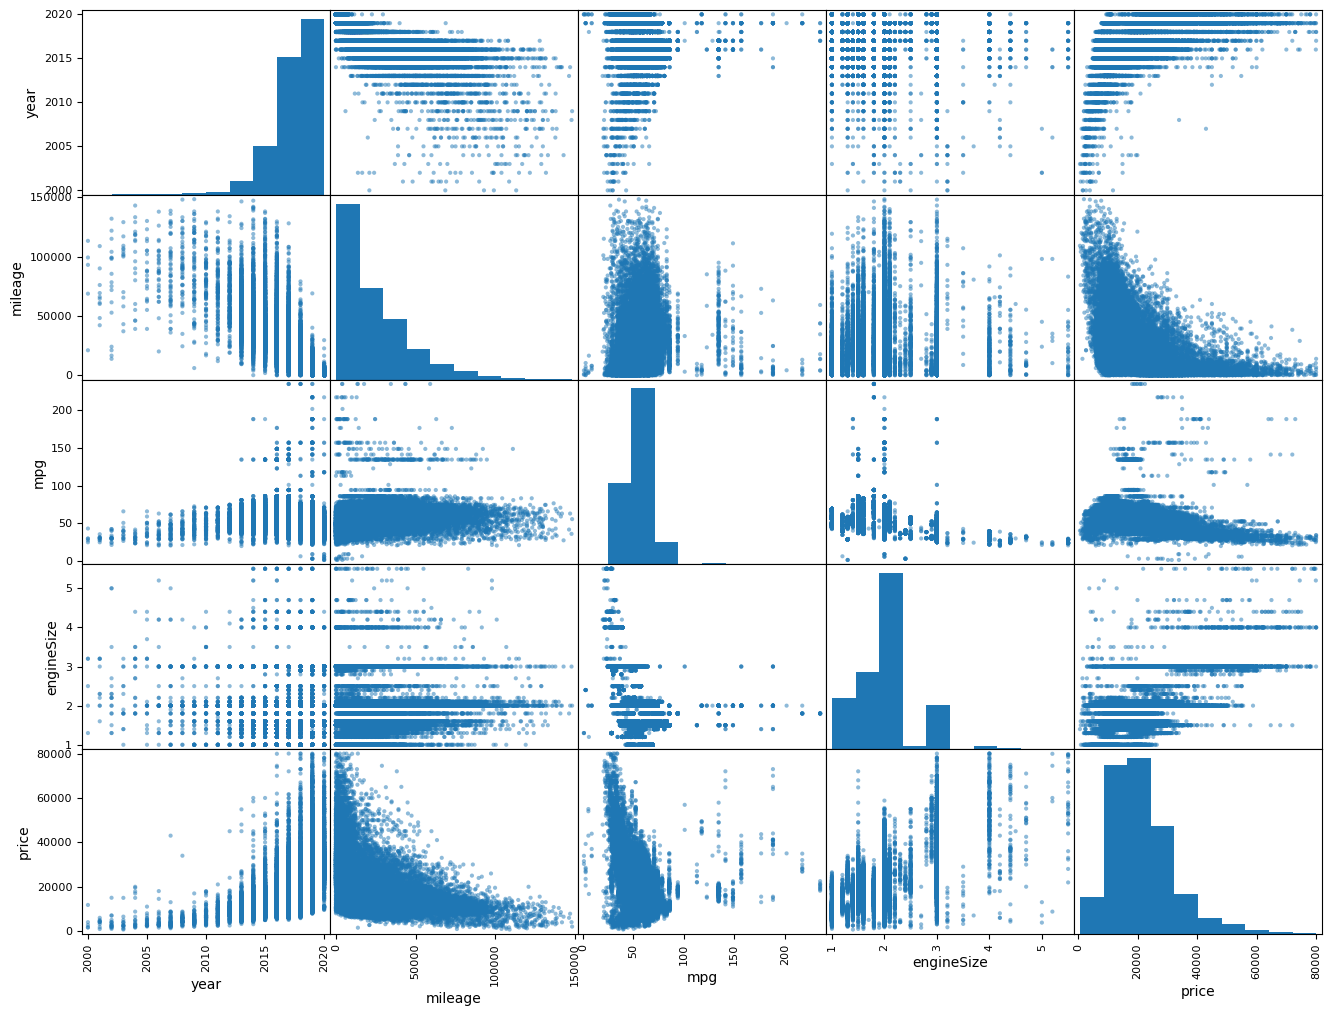

In [19]:
scatter_matrix(data_train[numerical_features], figsize=(16, 12))

Since every feature is correlated with the car price, I didn't delete any of them.

## Data preprocessing

I prepared the data for ML and I encoded the categorical feautures with a OneHotEncoder. For the numerical feauture instead I used a StandardScaler to scale and standardize features by removing the mean and scaling to unit variance.
I created two pipelines that define the transformations applyed to the numerical and categorical data for preprocessing the attributes.

I then used the Scikit-Learn method fit_transform and transform to apply the same transformation to the training, validation and test data; the first method calculates the parameters (like mean and standard deviation in StandardScaler class) and then simultaneously applies the transformation to the training data, while the second method only applies the transformation to the validation and test data using the parameters previously generated.

In [20]:
# Create X_train, y_train again, after the cleaning of the training data
X_train = data_train.copy()
y_train = X_train.pop("price")

numerical_trainingfeatures = ["year", "mileage", "mpg", "engineSize"]

# Create the first pipeline for numerical features
transformer_num = make_pipeline(
    SimpleImputer(strategy = "median"),
    StandardScaler(),
)

# Create the second pipeline for categorical feautures
transformer_cat = make_pipeline(
    SimpleImputer(strategy = "constant", fill_value = "NA"),
    OneHotEncoder(handle_unknown = "ignore"),
)

# Create a preprocessor with the transformation applied by the pipeline
preprocessor = make_column_transformer(
    (transformer_num, numerical_trainingfeatures),
    (transformer_cat, categorical_features),
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

## Training and evaluation of models

I considered and evaluated different models in order to find the best one. I compared the models using the metrics: Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

#### Linear Regression

Linear Regression - MAE: 2952.843875111865
Linear Regression - RMSE: 4686.288795208203


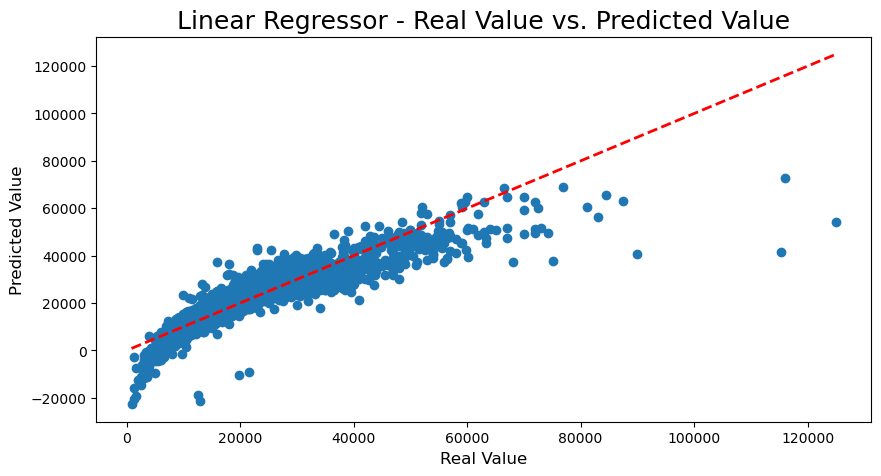

In [21]:
# Construction of the model
lr = LinearRegression()

# Fitting the model to the data
lr.fit(X_train, y_train)

# From unlabeled observations (X_test) the method predict returns the predicted labels y
lr_pred = lr.predict(X_val)

# Calculate MAE, MSE and RMSE
lr_mae = mean_absolute_error(y_val, lr_pred)
lr_mse = mean_squared_error(y_val, lr_pred)
lr_rmse = np.sqrt(lr_mse)
print("Linear Regression - MAE:", lr_mae)
print("Linear Regression - RMSE:", lr_rmse)

plt.figure(figsize = (10, 5))
plt.scatter(y_val, lr_pred)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Real Value", fontsize = 12)
plt.ylabel("Predicted Value", fontsize = 12)
plt.title("Linear Regressor - Real Value vs. Predicted Value", fontsize = 18)
plt.show()

#### Decision Tree

Decision Tree - MAE: 1815.5342128620996
Decision Tree - RMSE: 3131.602837391026


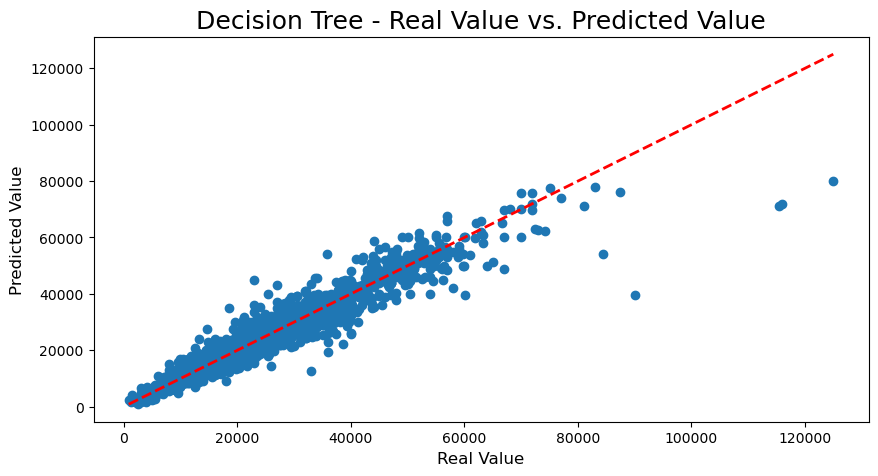

In [22]:
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_val)

tree_mae = mean_absolute_error(y_val, tree_pred)
tree_mse = mean_squared_error(y_val, tree_pred)
tree_rmse = np.sqrt(tree_mse)
print("Decision Tree - MAE:", tree_mae)
print("Decision Tree - RMSE:", tree_rmse)

plt.figure(figsize = (10, 5))
plt.scatter(y_val, tree_pred)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Real Value", fontsize = 12)
plt.ylabel("Predicted Value", fontsize = 12)
plt.title("Decision Tree - Real Value vs. Predicted Value", fontsize = 18)
plt.show()

#### Random forest

When considering random forest, I first used GridSearchCV for the hyperparameter tuning. The parameters to tune are:
- n_estimators (the number of decision trees in the forest);
- min_samples_split (the minimum number of samples required to split an internal node of each tree);
- min_samples_leaf (the minimum number of samples required to be at the leaf node of each tree);

I found that the best values for the parameters are: number of estimators = 400, min_samples_split = 7 and min_samples_leaf = 1. I then commented the line to avoid doing again the search if we train and calculate the prediction a second time. 

In [23]:
#rf = RandomForestRegressor()

#parameters = {
    #'n_estimators': [50 ,100, 200, 300, 400],
    #'min_samples_split': [2, 5, 7, 10],
    #'min_samples_leaf': [1, 2, 5]
#}

#grid_search = GridSearchCV(estimator=rf, param_grid=parameters, scoring='neg_mean_squared_error', cv=5, verbose=2)
#grid_search.fit(X_train, y_train)
#print("Best parameters: ", grid_search.best_params_)

Random Forest - MAE: 1446.8168879219754
Random Forest - RMSE: 2624.4281703879437


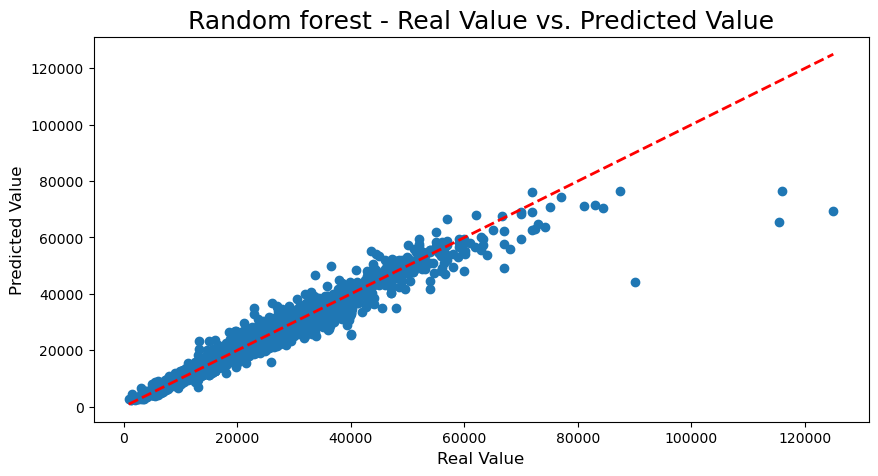

In [24]:
rf = RandomForestRegressor(n_estimators=400, min_samples_split=7, min_samples_leaf=1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

rf_mae = mean_absolute_error(y_val, rf_pred)
rf_mse = mean_squared_error(y_val, rf_pred)
rf_rmse = np.sqrt(rf_mse)
print("Random Forest - MAE:", rf_mae)
print("Random Forest - RMSE:", rf_rmse)

plt.figure(figsize = (10, 5))
plt.scatter(y_val, rf_pred)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Real Value", fontsize = 12)
plt.ylabel("Predicted Value", fontsize = 12)
plt.title("Random forest - Real Value vs. Predicted Value", fontsize = 18)
plt.show()

#### K-Nearest Neighbour

I used also for the K-Nearest Neighbour, the GridSearchCV to search for the best number of neighbors.
The best value for K is 4. I then commented, as I did before, the line to avoid doing again the search.

In [25]:
#knn = KNeighborsRegressor()

#parameter = {"n_neighbors": [3, 4, 5, 7, 9]}

#knn_model = KNeighborsRegressor()

#grid_search = GridSearchCV(estimator = knn, param_grid = parameter, scoring = "neg_mean_squared_error", cv = 5, verbose=2)
#grid_search.fit(X_train, y_train)
#print("Best parameter: ", grid_search.best_params_)

KNN - MAE: 1631.4048051319294
KNN - RMSE: 2895.533152957907


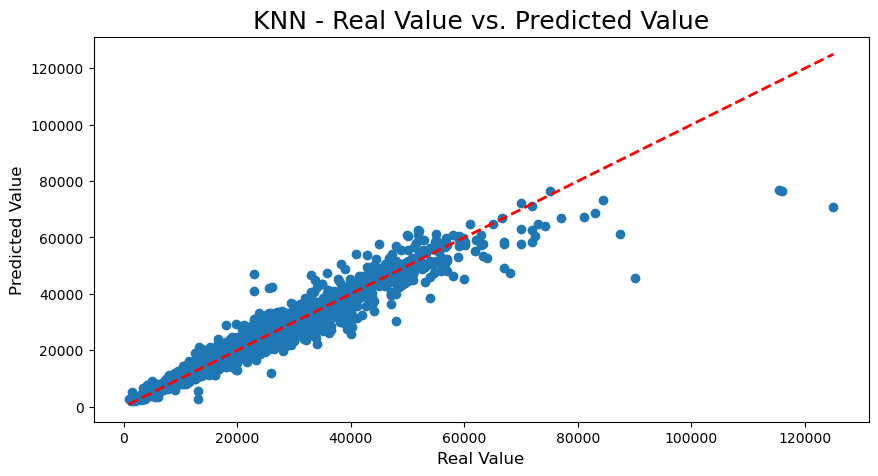

In [26]:
knn = KNeighborsRegressor(n_neighbors=4)  
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_val)

knn_mae = mean_absolute_error(y_val, knn_pred)
knn_mse = mean_squared_error(y_val, knn_pred)
knn_rmse = np.sqrt(knn_mse)
print("KNN - MAE:", knn_mae)
print("KNN - RMSE:", knn_rmse)

plt.figure(figsize = (10, 5))
plt.scatter(y_val, knn_pred)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Real Value", fontsize = 12)
plt.ylabel("Predicted Value", fontsize = 12)
plt.title("KNN - Real Value vs. Predicted Value", fontsize = 18)
plt.show()

#### Neural Network

The last model I considered is a neural network. I used keras_tuner to optimize the hyperparamters. 
First, I defined a function that creates and returns a Keras model. The hp argument in the function is used to define the hyperparameters during model creation.
The parameters to determine are:

- Number of units in input layer;
- Number of hidden layers;
- Number of units in each hidden layer;
- Use or not two dropout layer;
- Dropout Rate.

In [27]:
def build_model(hp):
    
    nn = Sequential()

    # First layer 
    nn.add(Dense(
            units=hp.Int("units", min_value=50, max_value=150, step=20),
            input_dim = X_train.shape[1],
            activation="relu",
            )
    )

    # First dropout rate
    dropoutRate = hp.Float("drRate", min_value=0.1, max_value=0.3, step=0.1)

    # Boolean to see if the first dropout layer is necessary
    if hp.Boolean("dropout"):
        nn.add(Dropout(rate=dropoutRate))

    # Number of layers and number of units in each layer 
    for i in range(hp.Int("num_layers", 1, 3)):
        nn.add(Dense(
                units=hp.Int(f"units_{i}", min_value=10, max_value=100, step=20),
                activation="relu",
         )
    )

    # Second dropout rate
    dropoutRate2 = hp.Float("drRate2", min_value=0.1, max_value=0.3, step=0.1)

    # Boolean to see if the second dropout layer is necessary
    if hp.Boolean("dropout2"):
        nn.add(Dropout(rate=dropoutRate2))

    # Last layer
    nn.add(Dense(
            units=1,
            activation='linear')
      )

    nn.compile(optimizer="adam",
                loss='mean_squared_error',
                metrics=['mean_absolute_error'])

    return nn

In [28]:
# Tuning with early stopping 

build_model(keras_tuner.HyperParameters())

# Initialize a tuner (Hyperband)
# I used overwrite = False to reload the tuner
tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_mean_absolute_error",
    overwrite=False,
    directory="kerastuner",
    project_name="ml_project",
)

# Define an EarlyStopping callback 
early_stopping = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=10)

# Start the search and get the parameters 
tuner.search_space_summary()
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from kerastuner/ml_project/tuner0.json
Search space summary
Default search space size: 9
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 150, 'step': 20, 'sampling': 'linear'}
drRate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 20, 'sampling': 'linear'}
drRate2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
dropout2 (Boolean)
{'default': False, 'conditions': []}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 20, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, '

In [29]:
# Print the best hyperparameters
num_layers = best_hps.get("num_layers")
units = []
for i in range(0, num_layers):
  units.append(best_hps.get(f"units_{i}"))

final_par = f"""
The best hyperparameters:
- the optimal number of units in the first layer is: {best_hps.get("units")};
- the optimal number of layers is: {best_hps.get("num_layers")};
- the optimal number of units in each layer is: {units};
- the optimal number of epochs is: {best_hps.get("tuner/epochs")};
- is dropout1 necessary: {best_hps.get("dropout")};
- is dropout2 necessary: {best_hps.get("dropout2")};
- the optimal starting epoch is: {best_hps.get("tuner/initial_epoch")};
"""

display(Markdown(final_par))


The best hyperparameters:
- the optimal number of units in the first layer is: 150;
- the optimal number of layers is: 3;
- the optimal number of units in each layer is: [70, 90, 90];
- the optimal number of epochs is: 100;
- is dropout1 necessary: False;
- is dropout2 necessary: False;
- the optimal starting epoch is: 34;


130/130 [==============================] - 0s 325us/step
NN - MAE: 1644.9608878267502
NN - RMSE: 2680.953644628451


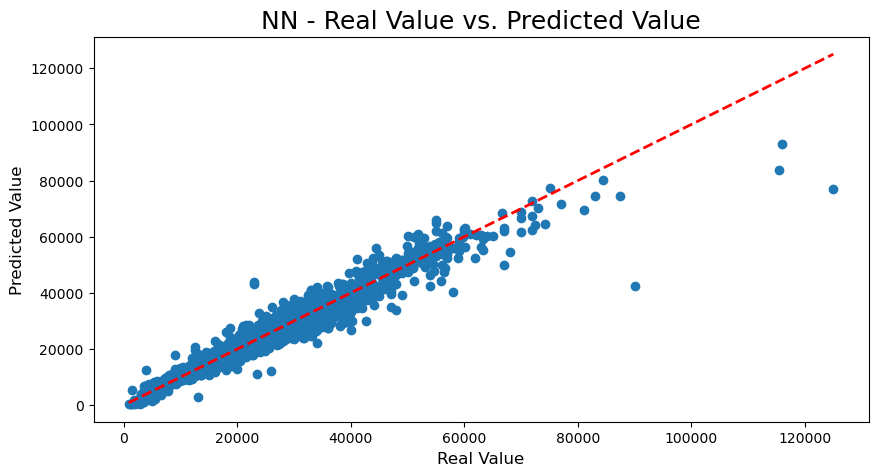

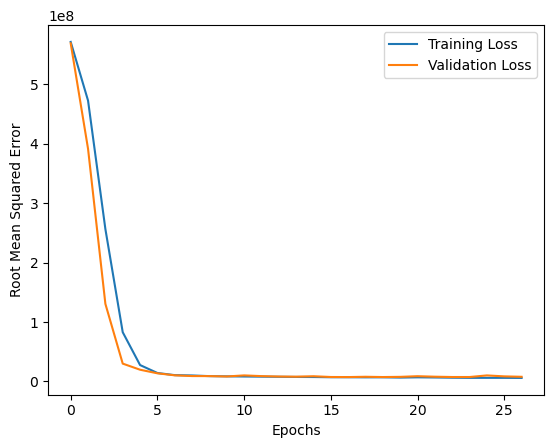

In [31]:
# Transform the data in array
X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()

# Final model construction with dense layers and batch normalization
nn = keras.Sequential([

    Dense(150, activation = "relu", input_shape = (X_train.shape[1],)),
    BatchNormalization(),
    
    Dense(70, activation = "relu"),
    BatchNormalization(),

    Dense(90, activation = "relu"),
    BatchNormalization(),
    
    Dense(90, activation = "relu"),

    Dense(1)
])

# Model compilation
nn.compile(optimizer = "adam", loss = "mean_squared_error",metrics=["mse"])

# Definition of the callback early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)

# Fitting the model for 100 epochs and early stopping
history = nn.fit(X_train_dense, y_train, initial_epoch = 34, epochs = 100, batch_size = 128, validation_data=(X_val_dense, y_val), callbacks = [early_stopping], verbose=0)

# Prediction on the validation set
nn_pred = nn.predict(X_val_dense)

# Calculate the metrics rmse and mae and print them 
nn_rmse = np.sqrt(mean_squared_error(y_val, nn_pred))
nn_mae = mean_absolute_error(y_val, nn_pred)
print("NN - MAE:",nn_mae)
print("NN - RMSE:", nn_rmse)
# Plot of the real values vs. predicted values
plt.figure(figsize = (10, 5))
plt.scatter(y_val, nn_pred)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Real Value", fontsize = 12)
plt.ylabel("Predicted Value", fontsize = 12)
plt.title("NN - Real Value vs. Predicted Value", fontsize = 18)
plt.show()

# Plot of the loss on the training set and the val_loss on the validation set, using as a metric the root mean squared error
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

## Conclusions

I compared the performance of the models, using the values measured before and I visualized the results with a bar chart.

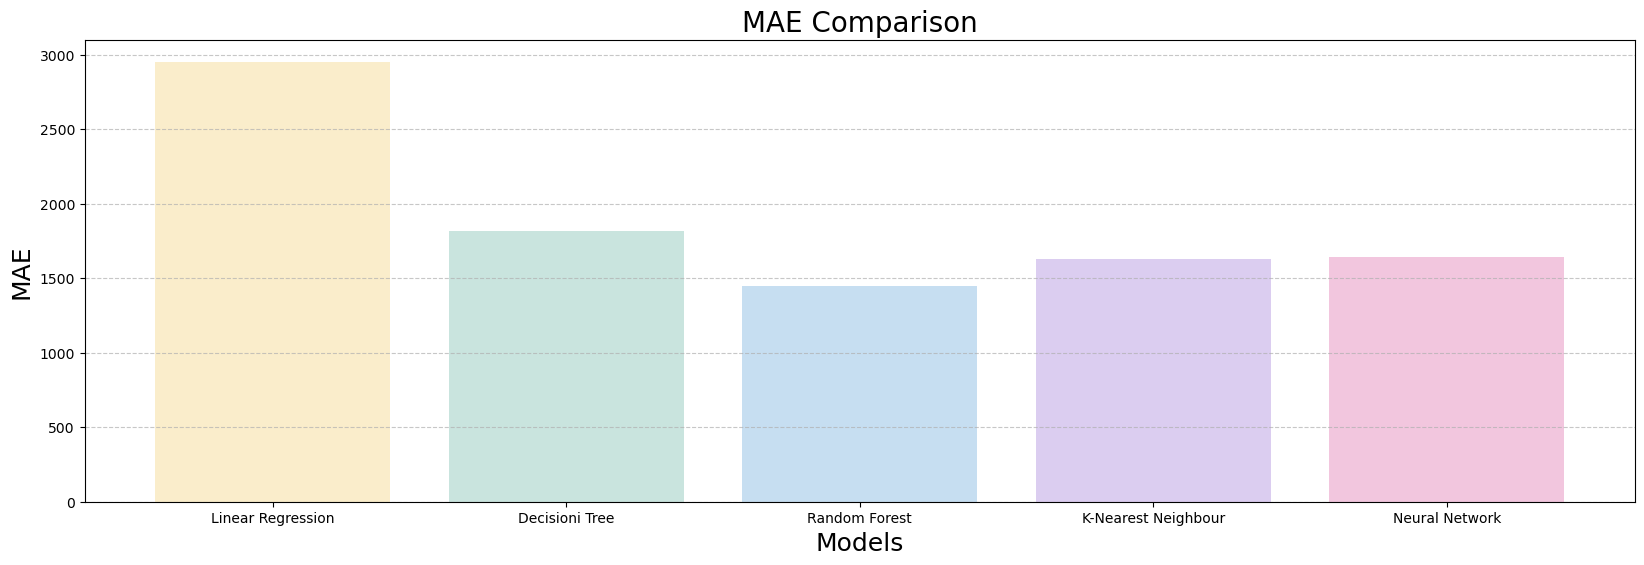

In [34]:
models = ['Linear Regression', 'Decisioni Tree', 'Random Forest', 'K-Nearest Neighbour', 'Neural Network']
mae = [lr_mae, tree_mae, rf_mae, knn_mae, nn_mae]
rmse = [lr_rmse, tree_rmse, rf_rmse, knn_rmse, nn_rmse]

# MAE plot
plt.figure(figsize=(20, 6))
bars = plt.bar(models, mae, color=['#faedcb','#c9e4de','#c6def1','#dbcdf0','#f2c6de'])
plt.xlabel('Models', fontsize = 18)
plt.ylabel('MAE', fontsize = 18)
plt.title('MAE Comparison', fontsize = 20)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show() 

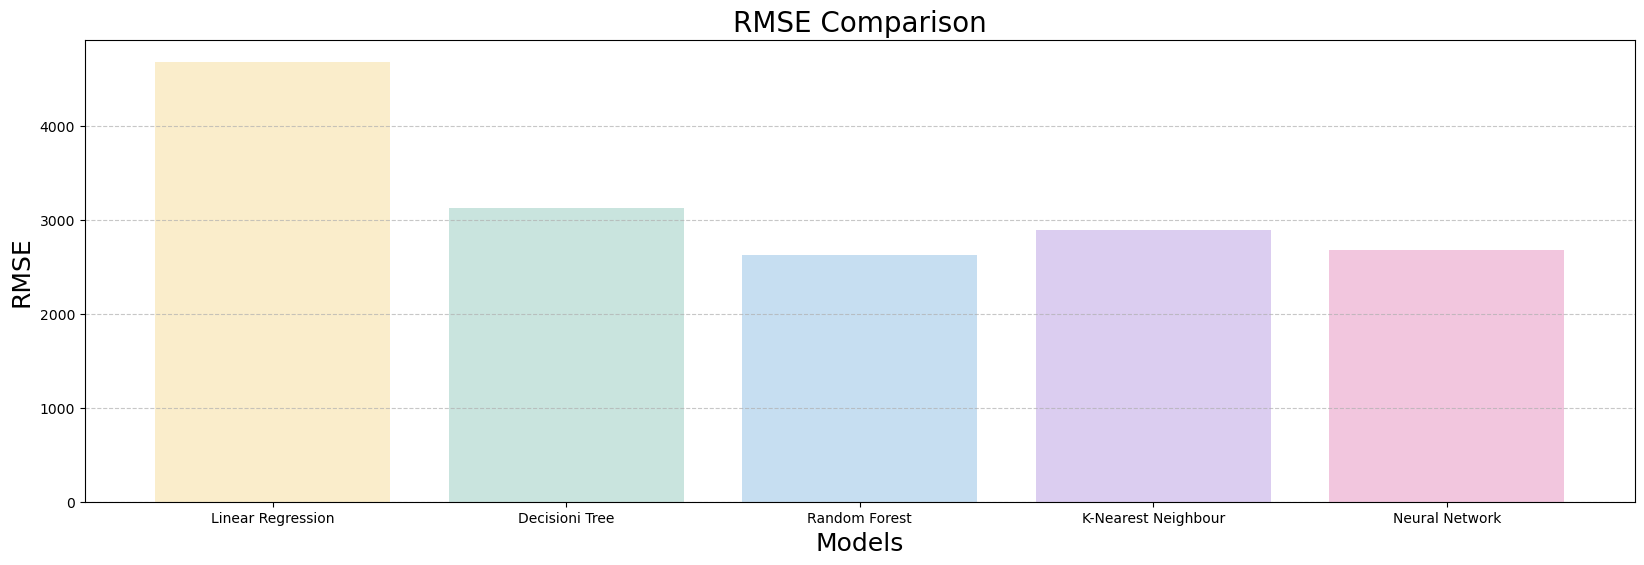

In [35]:
# RMSE plot
plt.figure(figsize=(20, 6))
bars = plt.bar(models, rmse, color=['#faedcb','#c9e4de','#c6def1','#dbcdf0','#f2c6de'])
plt.xlabel('Models', fontsize = 18)
plt.ylabel('RMSE', fontsize = 18)
plt.title('RMSE Comparison', fontsize = 20)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show() 

The model with the lowest MAE and lowest RMSE is the **Random Forest**, but also **K-Nearest Neighbour** and **Neural Networks** perform well for this task.

## Evaluation on test set

After considering the 3 best models, I tested them all on examples in the test set to see how well the models generalizes on new data. This last evaluation is used to check if the performance metrics on the test set are in line with the one measured before on the validation set.

In [36]:
final_predictions_rf = rf.predict(X_test)
final_mae_rf = mean_absolute_error(y_test, final_predictions_rf)
final_mse_rf = mean_squared_error(y_test, final_predictions_rf)
final_rmse_rf = np.sqrt(final_mse_rf)
print("Random Forest - MAE:", final_mae_rf)
print("Random Forest - RMSE:", final_rmse_rf)

Random Forest - MAE: 1510.4642535863488
Random Forest - RMSE: 3094.9353201370814


In [37]:
final_predictions_knn = knn.predict(X_test)
final_mae_knn = mean_absolute_error(y_test, final_predictions_knn)
final_mse_knn = mean_squared_error(y_test, final_predictions_knn)
final_rmse_knn = np.sqrt(final_mse_knn)
print("K-Nearest Neighbour - MAE:", final_mae_knn)
print("K-Nearest Neighbour - RMSE:", final_rmse_knn)

K-Nearest Neighbour - MAE: 1689.6049428379288
K-Nearest Neighbour - RMSE: 3313.376998180195


In [38]:
final_predictions_nn = nn.predict(X_test)
final_mae_nn = mean_absolute_error(y_test, final_predictions_nn)
final_mse_nn = mean_squared_error(y_test, final_predictions_nn)
final_rmse_nn = np.sqrt(final_mse_nn)
print("Neural Network - MAE:", final_mae_nn)
print("Neural Network - RMSE:", final_rmse_nn)

233/233 [==============================] - 0s 341us/step
Neural Network - MAE: 1700.4598056898392
Neural Network - RMSE: 2924.775382758275
